In [1]:
from pathlib import Path

n1 = 0
n2 = 1

data_dir = Path('../data/processed/dataset_01/patchwork_output/IGH/pairwise_alignments')


In [2]:
import pandas as pd
from immloom import segm_preprocess, segm_filter, plot_segments
import os

s_lst = os.listdir(data_dir)
s_lst = sorted([x[5:-4] for x in s_lst if x[:4]=='self'])


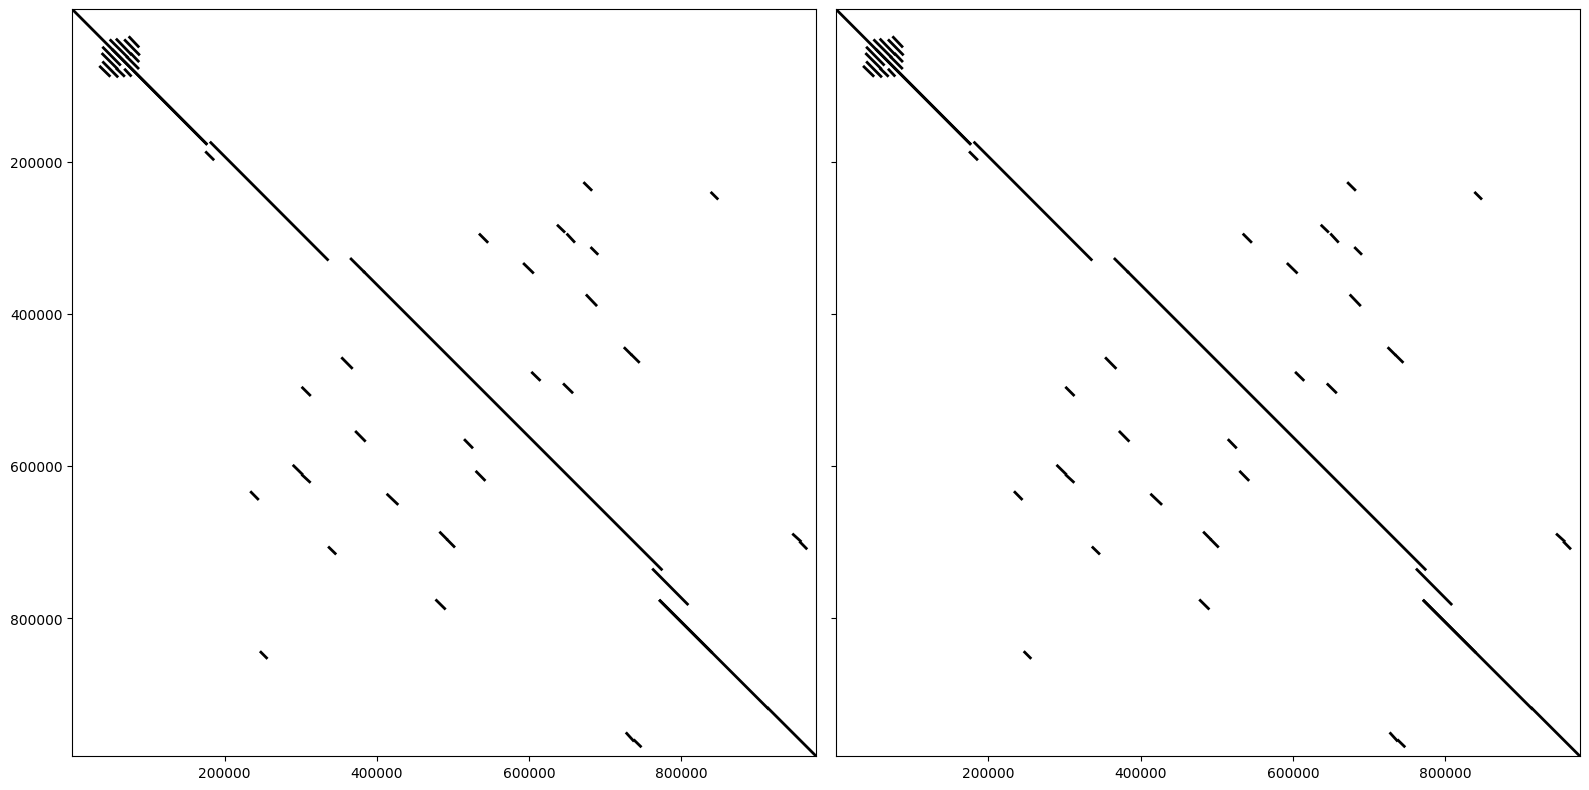

In [3]:
f_path = data_dir

if n1!=n2:
    f_name = f'pair_{s_lst[n1]}_{s_lst[n2]}.tsv'
else:
    f_name = f'self_{s_lst[n1]}.tsv'

df = segm_preprocess(f_path, f_name)
df1_all = segm_filter(df, pi=80.0, length=10000)
df1 = df1_all[df1_all.strand=='+']

plot_segments(df1_all, df1)

In [4]:
dfx = pd.read_csv(f'../immloom_out/self_{s_lst[n1]}/block.tsv', sep='\t')
dfy = pd.read_csv(f'../immloom_out/self_{s_lst[n2]}/block.tsv', sep='\t')

In [5]:
from math import sqrt
from typing import List, Tuple, Dict, Set, Optional


def split_segments_sdir(df: pd.DataFrame, split_points: Optional[List[int]] = None, 
                   length_min: Optional[int] = None, sdir='vert') -> pd.DataFrame:
    """
    Split segments by given split_points (list of coordinates). If split_points is None,
    build them from all segment endpoints, merging very close points (<5) into one.
    """
    if split_points is None:
        split_points = sorted(list(set(list(df.x1) + list(df.x2) + list(df.y1) + list(df.y2))))

    segm_lst = []
    for _, row in df.iterrows():
        x1, y1, x2, y2, strand = row.x1, row.y1, row.x2, row.y2, row.strand
        points = [(x1, y1), (x2, y2)]
        if strand == '+':
            if sdir=='vert':
                for xt in split_points:
                    if x1 < xt < x2:
                        yt = int(y1 + (y2 - y1) / (x2 - x1) * (xt - x1))
                        points.append((xt, yt))
                        points.append((xt+1, yt+1))
            else:
                for yt in split_points:
                    if y1 < yt < y2:
                        xt = int(x1 + (x2 - x1) / (y2 - y1) * (yt - y1))
                        points.append((xt, yt))
                        points.append((xt+1, yt+1))

        points = sorted(points, key=lambda p: p[0])
        for (xa, ya), (xb, yb) in zip(points[:-1], points[1:]):
            segm_lst.append({'x1': int(xa), 'y1': int(ya), 'x2': int(xb), 'y2': int(yb), 'strand': strand})
    df1 = pd.DataFrame(segm_lst)
    if df1.empty:
        return df1
    df1['length'] = df1.apply(lambda x: int(sqrt((x.x2 - x.x1)**2 + (x.y2 - x.y1)**2)), axis=1)
    if length_min is not None:
        df1 = df1[df1.length >= length_min]
    return df1[['x1', 'x2', 'y1', 'y2', 'strand', 'length']].reset_index(drop=True)

split_points = sorted(list(set(list(dfx.d1)+list(dfx.d2))))
df2 = split_segments_sdir(df1, split_points=split_points)

split_points = sorted(list(set(list(dfy.d1)+list(dfy.d2))))
df3 = split_segments_sdir(df2, split_points=split_points, sdir='horiz')

In [6]:
df3['in_x'] = df3.apply(
    lambda r: ((dfx['d1'] <= r['x1']) & (dfx['d2'] >= r['x2'])).any(),
    axis=1
)

df3['in_y'] = df3.apply(
    lambda r: ((dfy['d1'] <= r['y1']) & (dfy['d2'] >= r['y2'])).any(),
    axis=1
)

df3 = df3[df3.length>=2000]

In [7]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

def plot_segments_color(df: pd.DataFrame, *,
                        save_path: Path | str | None = None,
                        show: bool = False,
                        title: str | None = None,
                        linewidth: float = 2.0,
                        alpha: float = 0.9,
                        figsize=(10, 8)):
    """
    Plot segments colored by membership flags 'in_x' and 'in_y'.

    Color scheme:
      - red    : neither in_x nor in_y
      - blue   : in_x only
      - yellow : in_y only
      - green  : both in_x and in_y
    """
    if df is None or len(df) == 0:
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title(title or "No segments to plot")
        if save_path:
            Path(save_path).parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, bbox_inches="tight", dpi=150)
            plt.close(fig)
        elif show:
            plt.show()
        return fig, ax

    required = ['x1', 'x2', 'y1', 'y2']
    for c in required:
        if c not in df.columns:
            raise ValueError(f"DataFrame must contain column '{c}'")

    df_plot = df.dropna(subset=required).copy()

    # Normalize flags to booleans if present
    def to_bool_col(df_local, col):
        if col not in df_local.columns:
            return pd.Series([False] * len(df_local), index=df_local.index)
        return df_local[col].astype(bool)

    in_x = to_bool_col(df_plot, 'in_x')
    in_y = to_bool_col(df_plot, 'in_y')

    both_mask = in_x & in_y
    only_x_mask = in_x & ~in_y
    only_y_mask = in_y & ~in_x
    none_mask = ~in_x & ~in_y

    # extents for plotting limits (safe)
    x_vals = df_plot[['x1', 'x2']].values
    y_vals = df_plot[['y1', 'y2']].values
    x_min = int(np.nanmin(x_vals))
    x_max = int(np.nanmax(x_vals))
    y_min = int(np.nanmin(y_vals))
    y_max = int(np.nanmax(y_vals))

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # plot order: none (red) → only_x (blue) → only_y (yellow) → both (green)
    color_specs = [
        (none_mask,  'red',    'none (neither)'),
        (only_x_mask,'blue',   'only x'),
        (only_y_mask,'yellow', 'only y'),
        (both_mask,  'green',  'both x & y'),
    ]

    for mask, color, label in color_specs:
        df_subset = df_plot[mask]
        for _, row in df_subset.iterrows():
            ax.plot([row['x1'], row['x2']], [row['y1'], row['y2']],
                    linewidth=linewidth, color=color, alpha=alpha)
    # Build legend (one handle per category)
    from matplotlib.lines import Line2D
    legend_elems = [Line2D([0], [0], color=c, lw=3, label=l) for (_, c, l) in color_specs]
    ax.legend(handles=legend_elems, loc='best')

    ax.set_title(title or '')
    ax.set_aspect('equal', 'box')
    xpad = max(1, (x_max - x_min) * 0.02)
    ypad = max(1, (y_max - y_min) * 0.02)
    ax.set_xlim(x_min - xpad, x_max + xpad)
    ax.set_ylim(y_max + ypad, y_min - ypad)  # invert y by swapping if needed

    ax.set_xlabel('x')
    ax.set_ylabel('y')

    plt.tight_layout()

    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
        plt.close(fig)
    else:
        if show:
            plt.show()

    return fig, ax


(<Figure size 1000x800 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

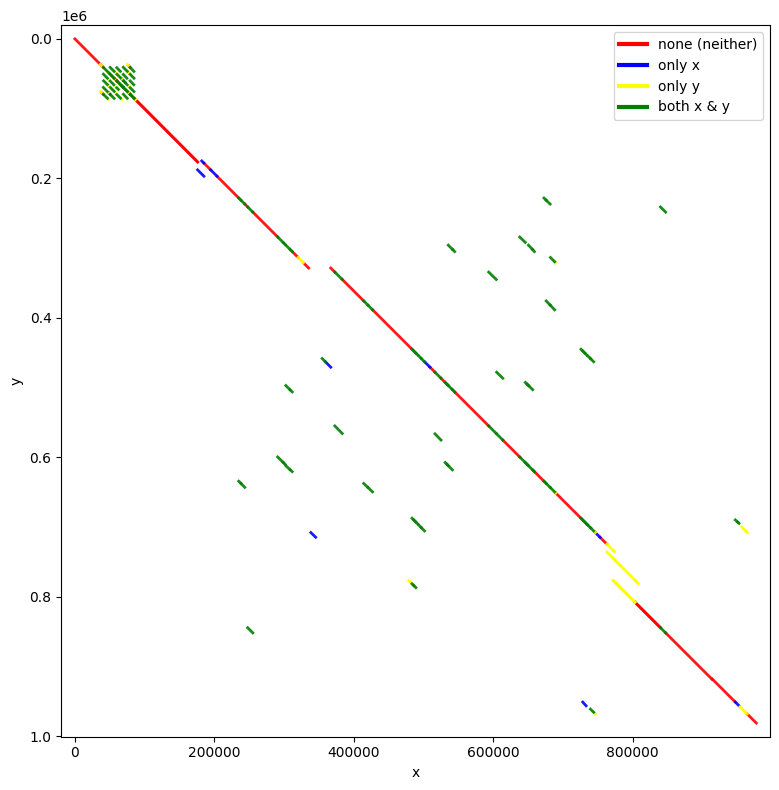

In [8]:
plot_segments_color(df3)

In [9]:
print(df3[df3.in_x & df3.in_y].length.sum()/df3.length.sum())
print(df3[df3.in_x & ~df3.in_y].length.sum()/df3.length.sum())
print(df3[~df3.in_x & df3.in_y].length.sum()/df3.length.sum())
print(df3[~df3.in_x & ~df3.in_y].length.sum()/df3.length.sum())

0.3582497175563211
0.040613848761364674
0.1218338974708074
0.47930253621150676


In [10]:
# 0 0

# 0.4502116279992182
# 0.01395640898084524
# 0.014198692814205575
# 0.521633270205731

In [11]:
print(dfx.head())
print(dfy.head())
print(df3.head())

df3['in_x'] = df3.apply(
    lambda r: ((dfx['d1'] <= r['x1']) & (dfx['d2'] >= r['x2'])).any(),
    axis=1
)

df3['in_y'] = df3.apply(
    lambda r: ((dfy['d1'] <= r['y1']) & (dfy['d2'] >= r['y2'])).any(),
    axis=1
)

   block_id     d1     d2
0         1  40814  46702
1         2  48911  50440
2         1  50638  56453
3         1  60139  65534
4         2  67716  69251
   block_id     d1     d2
0         2  36754  38383
1         1  40793  46624
2         2  46625  48211
3         3  48917  50449
4         1  50647  56422
       x1     x2     y1     y2 strand  length   in_x   in_y
0      62  36700      1  36754      +   51895  False  False
2   36701  38324  36755  38383      +    2298  False   True
4   38325  40727  38384  40793      +    3401  False  False
8   40815  46539  40881  46624      +    8108   True   True
14  46703  48121  46788  48211      +    2008  False   True


In [12]:
import pandas as pd

def find_block_id(row, blocks_df, prefix):
    # mask rows in blocks_df where block.d1 <= row[f'{prefix}1'] and block.d2 >= row[f'{prefix}2']
    mask = (blocks_df['d1'] <= row[f'{prefix}1']) & (blocks_df['d2'] >= row[f'{prefix}2'])
    return blocks_df.loc[mask, 'block_id'].iat[0] if mask.any() else pd.NA

df4 = df3.copy()
df4['block_id_x'] = df4.apply(lambda r: find_block_id(r, dfx, 'x'), axis=1)
df4['block_id_y'] = df4.apply(lambda r: find_block_id(r, dfy, 'y'), axis=1)


In [13]:
df4

,x1,x2,y1,y2,strand,length,in_x,in_y,block_id_x,block_id_y
0,62,36700,1,36754,+,51895,False,False,<NA>,<NA>
2,36701,38324,36755,38383,+,2298,False,True,<NA>,2
4,38325,40727,38384,40793,+,3401,False,False,<NA>,<NA>
8,40815,46539,40881,46624,+,8108,True,True,1,1
14,46703,48121,46788,48211,+,2008,False,True,<NA>,2
...,...,...,...,...,...,...,...,...,...,...
1079,964123,977228,968052,981148,+,18526,False,False,<NA>,<NA>
1082,947140,950616,689906,693066,+,4697,True,True,17,16
1086,950618,952454,693068,694736,+,2480,True,True,17,17
1101,956389,961754,700120,705598,+,7667,False,True,<NA>,18


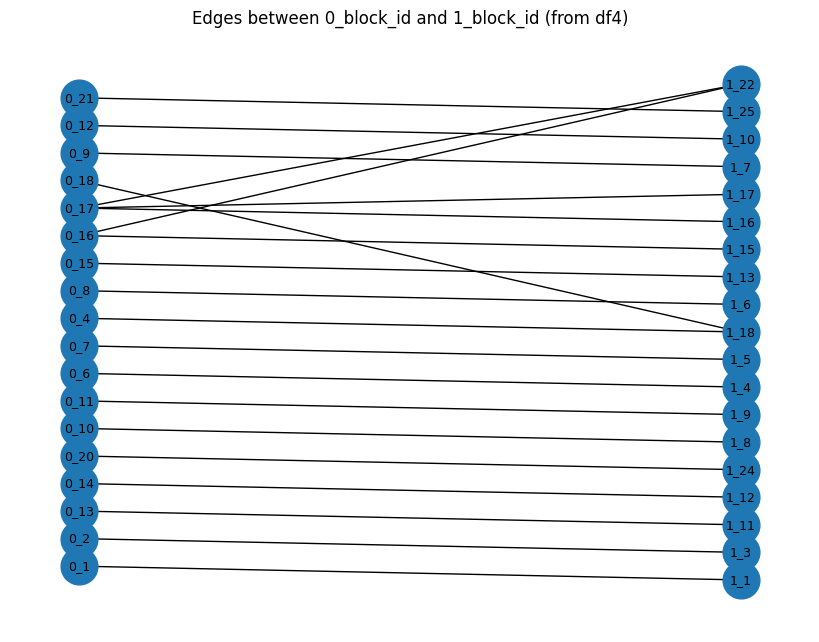

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def find_block_id(row, blocks_df, prefix):
    mask = (blocks_df['d1'] <= row[f'{prefix}1']) & (blocks_df['d2'] >= row[f'{prefix}2'])
    return blocks_df.loc[mask, 'block_id'].iat[0] if mask.any() else pd.NA

def create_and_plot_graph(dfx, dfy, df4, n1='n1', n2='n2', figsize=(8,6)):
    if 'block_id_x' not in df4.columns:
        df4['block_id_x'] = df4.apply(lambda r: find_block_id(r, dfx, 'x'), axis=1)
    if 'block_id_y' not in df4.columns:
        df4['block_id_y'] = df4.apply(lambda r: find_block_id(r, dfy, 'y'), axis=1)
    def prefixed_bid(prefix, bid):
        return f"{prefix}_{int(bid)}" if pd.notna(bid) else None
    edges = []
    for _, r in df4.iterrows():
        bx = prefixed_bid(n1, r.get('block_id_x'))
        by = prefixed_bid(n2, r.get('block_id_y'))
        if bx is not None and by is not None:
            edges.append((bx, by))
    G = nx.Graph()
    G.add_edges_from(edges)
    plt.figure(figsize=figsize)
    if len(G) == 0:
        plt.text(0.5, 0.5, "Graph is empty (no edges between prefixed block ids)", ha='center', va='center')
        plt.axis('off')
    else:
        left_nodes = [n for n in G.nodes if str(n).startswith(f"{n1}_")]
        right_nodes = [n for n in G.nodes if str(n).startswith(f"{n2}_")]
        if left_nodes and right_nodes:
            pos = {}
            for i, node in enumerate(left_nodes):
                pos[node] = (-1, (i - len(left_nodes)/2))
            for i, node in enumerate(right_nodes):
                pos[node] = (1, (i - len(right_nodes)/2))
            combined = nx.spring_layout(G, pos=pos, fixed=list(pos.keys()), seed=3)
            pos = combined
        else:
            pos = nx.spring_layout(G, seed=4)
        nx.draw(G, pos, with_labels=True, node_size=700, font_size=9)
    plt.title(f"Edges between {n1}_block_id and {n2}_block_id (from df4)")
    plt.show()
    return G

G = create_and_plot_graph(dfx, dfy, df4, n1, n2)

In [15]:
# Сохранение графа в TSV (notebook cell)
import os
import pandas as pd
import networkx as nx

# Параметры: G, df4, n1, n2 должны быть уже в окружении
# Пример: G = create_and_plot_graph(dfx, dfy, df4, n1, n2)

out_dir = "graphs"
os.makedirs(out_dir, exist_ok=True)

# 1) Сохраним ребра (агрегированно по количеству появлений в df4, чтобы сохранить мульти-ребра)
if 'block_id_x' in df4.columns and 'block_id_y' in df4.columns:
    edges_df = (
        df4
        .dropna(subset=['block_id_x', 'block_id_y'])                  # только строки с обеими block_id
        .assign(
            source=lambda d: d['block_id_x'].apply(lambda x: f"{n1}_{int(x)}"),
            target=lambda d: d['block_id_y'].apply(lambda x: f"{n2}_{int(x)}")
        )
        .groupby(['source', 'target'])
        .size()
        .reset_index(name='count')                                   # count = число совпадений в df4
    )
else:
    # fallback: получим ребра непосредственно из NetworkX (каждое ребро один раз)
    edges_df = nx.to_pandas_edgelist(G).rename(columns={'source':'source','target':'target'})
    if 'weight' not in edges_df.columns:
        edges_df['count'] = 1

edge_path = os.path.join(out_dir, f"G-{n1}-{n2}.tsv")
edges_df.to_csv(edge_path, sep='\t', index=False)
print(f"Saved edges -> {edge_path}")
print(edges_df.head())

# 2) Сохранить вершины (node, side (which sample), degree)
nodes = list(G.nodes())
nodes_df = pd.DataFrame({'node': nodes})
# определим сторону (n1 или n2) по префиксу
def side_of(node):
    s = str(node)
    if s.startswith(f"{n1}_"):
        return n1
    if s.startswith(f"{n2}_"):
        return n2
    return "unknown"
nodes_df['side'] = nodes_df['node'].apply(side_of)
# добавим degree и (опционально) bipartite flag
deg = dict(G.degree())
nodes_df['degree'] = nodes_df['node'].map(deg).fillna(0).astype(int)

nodes_path = os.path.join(out_dir, f"G-{n1}-{n2}-nodes.tsv")
nodes_df.to_csv(nodes_path, sep='\t', index=False)
print(f"Saved nodes -> {nodes_path}")
print(nodes_df.head())

# 3) Как загрузить граф обратно (если понадобится)
# from saved edges:
# edges_loaded = pd.read_csv(edge_path, sep='\t')
# G_loaded = nx.from_pandas_edgelist(edges_loaded, source='source', target='target', edge_attr=True)
# Если вы хотите восстановить multiplicity: убедитесь, что у вас есть столбец 'count' и используйте его как вес:
# G_loaded = nx.from_pandas_edgelist(edges_loaded, source='source', target='target', edge_attr='count')

print("Done.")


Saved edges -> graphs/G-0-1.tsv
  source target  count
0    0_1    1_1     30
1   0_10    1_8      4
2   0_11    1_9      6
3   0_12   1_10      4
4   0_13   1_11      4
Saved nodes -> graphs/G-0-1-nodes.tsv
   node  side  degree
0   0_1     0       1
1   1_1     1       1
2   0_2     0       1
3   1_3     1       1
4  0_13     0       1
Done.


In [16]:
!ls graphs

G-0-1-nodes.tsv    G-1-3-nodes.tsv    G-2-6-nodes.tsv    G-4-7-nodes.tsv
G-0-1.tsv          G-1-3.tsv          G-2-6.tsv          G-4-7.tsv
G-0-2-nodes.tsv    G-1-4-nodes.tsv    G-2-7-nodes.tsv    G-5-6-nodes.tsv
G-0-2.tsv          G-1-4.tsv          G-2-7.tsv          G-5-6.tsv
G-0-3-nodes.tsv    G-1-5-nodes.tsv    G-3-4-nodes.tsv    G-5-7-nodes.tsv
G-0-3.tsv          G-1-5.tsv          G-3-4.tsv          G-5-7.tsv
G-0-4-nodes.tsv    G-1-6-nodes.tsv    G-3-5-nodes.tsv    G-6-7-nodes.tsv
G-0-4.tsv          G-1-6.tsv          G-3-5.tsv          G-6-7.tsv
G-0-5-nodes.tsv    G-1-7-nodes.tsv    G-3-6-nodes.tsv    G-merged-nodes.tsv
G-0-5.tsv          G-1-7.tsv          G-3-6.tsv          G-merged-sns.png
G-0-6-nodes.tsv    G-2-3-nodes.tsv    G-3-7-nodes.tsv    G-merged.png
G-0-6.tsv          G-2-3.tsv          G-3-7.tsv          G-merged.tsv
G-0-7-nodes.tsv    G-2-4-nodes.tsv    G-4-5-nodes.tsv    components_sns
G-0-7.tsv          G-2-4.tsv          G-4-5.tsv
G-1-2-nodes.tsv    G-2-5-nodes

In [17]:
e = os.listdir('graphs')
e = [x for x in e if x[-4:]=='.tsv']
len(e)

58